In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances


class Particles():
    
    def __init__(self, n, landmark):
        self.landmark = landmark
        xy = np.random.randn(n, 2) * 0.1
        theta = np.random.uniform(0, np.pi * 2, n)
        self.S = np.c_[xy, theta]
        self.w = np.ones(n)/n
        self.history = [self.S]
        
    def motion_model(self, distance, angle=0):
        x, y, theta = self.S.T
        theta_new = theta+angle
        x_noise = np.random.normal(0, distance*0.1, size=len(theta))
        y_noise = np.random.normal(0, distance*0.1, size=len(theta))
        dx = np.cos(theta_new) * distance + x_noise
        dy = np.sin(theta_new) * distance + y_noise
        self.S = np.c_[x + dx, y + dy, theta_new]
        self.history.append(self.S)
    
    def measurement_model(self, obs):
        distance = euclidean_distances(self.S[:, :2], self.landmark)
        noise = np.random.normal(0, 0.05, size=distance.shape)
        observe_model = distance + noise
        P_z_x = np.c_[[norm(loc=obs[i], scale=0.05).pdf(observe_model[:, i]) for i in range(len(obs))]].T
        self.w = np.prod(P_z_x, axis=1)
        self.w /= self.w.sum()
        
    def resample(self):
        n = len(self.S)
        indices = np.random.choice(range(n), size=n, p=self.w)
        self.S = self.S[indices]
        self.history.append(self.S)
        
class Robot():
    def __init__(self, x, y, theta, landmark):
        self.state = [x, y, theta]
        self.landmark = landmark
        self.history = [self.state]
        
    def move(self, distance, angle):
        x, y, theta = self.state
        theta_new = theta + angle
        x_noise = np.random.normal(0, distance*0.1)
        y_noise = np.random.normal(0, distance*0.1)
        dx = np.cos(theta_new) * distance + x_noise
        dy = np.sin(theta_new) * distance + y_noise
        self.state = [x + dx, y + dy, theta_new]
        self.history.append(self.state)
        
    def observe(self):
        x = np.array(self.state).reshape(1, -1)
        distance = euclidean_distances(x[:, :2], self.landmark).ravel()
        noise = np.random.normal(0, 0.05, size=distance.shape)
        return distance + noise
    
    def step(self, distance, angle=0):
        self.move(distance, angle)
        return self.observe()



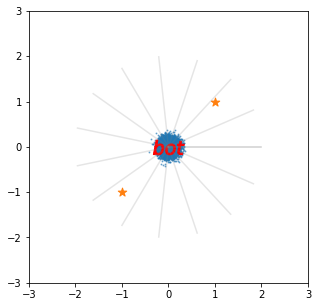

In [161]:
landmark = np.array([[1, 1], 
                     [-1, -1]])

robot_env = Robot(0, 0, np.pi/2, landmark)
particl_model = Particles(10000, landmark)

motions = [[1, 0],
           [0.5, -np.pi/6],
           [1, np.pi/3]]

for distance, angle in motions:
    obs = robot_env.step(distance, angle)
    
    particl_model.motion_model(distance, angle)
    particl_model.measurement_model(obs)
    particl_model.resample()
    

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def drawAni(i):
    ax.cla()
    
    p = particl_model.history[i]
    r = robot_env.history[(i+1)//2]
    ax.scatter(p[:, 0], p[:, 1], s=1, alpha=0.5)
    
    angles = np.linspace(0, 2, 16) * np.pi
    x = np.cos(angles) * 2 + r[0]
    y = np.sin(angles) * 2 + r[1]
    for i in range(len(x)):
        ax.plot([r[0], x[i]], [r[1], y[i]], c='gray', alpha=0.2)
    ax.scatter(r[:1], r[1:2], c='r', s=1000, marker=r'$bot$', linewidth=1)
    
    ax.scatter(landmark[:, 0], landmark[:, 1], s=80, marker='*')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
anim = FuncAnimation(fig, drawAni, interval=1000, frames=range(len(particl_model.history)))
HTML(anim.to_html5_video())